In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from joblib import dump

In [2]:
claims_df = pd.read_csv('../data/processed/dim_claims_train.csv')

claims_X = claims_df[['bin', 'drug']]
claims_y = claims_df['pharmacy_claim_approved']

# Tasks
- Final Optimization of Hyperparameters
    - False positives have been determined to be worse than false negatives.
    - Reducing false positives can be performed by prioritizing recall.
    - It has been demonstrated that the minimum number of leaves can be achieved through three methods:
        1. (easiest) Setting `max_leaf_nodes` to the desired number of leaves.
        2. Increasing `ccp_alpha` or `min_impurity_decrease`.
- Test Split Model Evaluation

In [3]:
def build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes):
    encoder = OneHotEncoder(sparse=False, drop='first')
    model = DecisionTreeClassifier(random_state=42, 
                                   ccp_alpha=ccp_alpha, 
                                   min_impurity_decrease=min_impurity_decrease,
                                   max_leaf_nodes=max_leaf_nodes)
    pipe = Pipeline([('encoder', encoder),
                     ('model', model)])
    return pipe   

## Model without Constraints

In [4]:
ccp_alpha = 0
min_impurity_decrease = 0
max_leaf_nodes = 12

pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
pipe.fit(claims_X, claims_y)
ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']

## Model with `max_leaf_node` Scan

In [5]:
fit_results = []

ccp_alpha = 0
min_impurity_decrease = 0

for max_leaf_nodes in range(5, 12):
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv.get_n_splits(claims_X)

    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    n_leaves = []

    for train_index, test_index in cv.split(claims_X):
        X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
        y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

        pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
        pipe.fit(X_train, y_train)

        accuracy.append(accuracy_score(y_test, pipe.predict(X_test)))
        precision.append(precision_score(y_test, pipe.predict(X_test)))
        recall.append(recall_score(y_test, pipe.predict(X_test)))
        roc_auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))
        n_leaves.append(pipe['model'].get_n_leaves())

    accuracy = np.mean(accuracy)
    recall = np.mean(recall)
    precision = np.mean(precision)
    roc_auc = np.mean(roc_auc)
    n_leaves = np.mean(n_leaves)

    fit_results.append({'ccp_alpha': ccp_alpha,
                        'min_impurity_decrease': min_impurity_decrease,
                        'max_leaves': max_leaf_nodes,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'roc_auc': roc_auc,
                        'n_leaves': n_leaves})

## Model with `min_impurity_decrease` and `ccp_alpha` Scan

In [6]:
max_leaf_nodes = 12

for min_impurity_decrease in np.linspace(0, 10**-6, 10):
    for ccp_alpha in ccp_alphas:
        cv = KFold(n_splits=5, random_state=42, shuffle=True)
        cv.get_n_splits(claims_X)

        accuracy = []
        precision = []
        recall = []
        roc_auc = []
        n_leaves = []

        for train_index, test_index in cv.split(claims_X):
            X_train, X_test = claims_X.iloc[train_index], claims_X.iloc[test_index]
            y_train, y_test = claims_y.iloc[train_index], claims_y.iloc[test_index]

            pipe = build_pipe(ccp_alpha, min_impurity_decrease, max_leaf_nodes)
            pipe.fit(X_train, y_train)

            accuracy.append(accuracy_score(y_test, pipe.predict(X_test)))
            precision.append(precision_score(y_test, pipe.predict(X_test)))
            recall.append(recall_score(y_test, pipe.predict(X_test)))
            roc_auc.append(roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))
            n_leaves.append(pipe['model'].get_n_leaves())

        accuracy = np.mean(accuracy)
        recall = np.mean(recall)
        precision = np.mean(precision)
        roc_auc = np.mean(roc_auc)
        n_leaves = np.mean(n_leaves)

        fit_results.append({'ccp_alpha': ccp_alpha,
                            'min_impurity_decrease': min_impurity_decrease,
                            'max_leaves': max_leaf_nodes,
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall': recall,
                            'roc_auc': roc_auc,
                            'n_leaves': n_leaves})
        if recall < 1:
            break

    ccp_alphas = pipe['model'].cost_complexity_pruning_path(pipe['encoder'].transform(claims_X), claims_y)['ccp_alphas']
fit_results = pd.DataFrame(fit_results)

## Results with Maximum Recall

In [7]:
fit_results.loc[fit_results['recall'] == 1].sort_values('n_leaves')

,ccp_alpha,min_impurity_decrease,max_leaves,accuracy,precision,recall,roc_auc,n_leaves
4,0.000000e+00,0.000000e+00,9,0.935283,0.90021,1.0,0.922518,9.0
25,0.000000e+00,7.777778e-07,12,0.935283,0.90021,1.0,0.922518,9.0
23,0.000000e+00,6.666667e-07,12,0.935283,0.90021,1.0,0.922518,9.0
21,0.000000e+00,5.555556e-07,12,0.935283,0.90021,1.0,0.922518,9.0
19,0.000000e+00,4.444444e-07,12,0.935283,0.90021,1.0,0.922518,9.0
17,0.000000e+00,3.333333e-07,12,0.935283,0.90021,1.0,0.922518,9.0
15,0.000000e+00,2.222222e-07,12,0.935283,0.90021,1.0,0.922518,9.0
27,0.000000e+00,8.888889e-07,12,0.935283,0.90021,1.0,0.922518,9.0
29,0.000000e+00,1.000000e-06,12,0.935283,0.90021,1.0,0.922518,9.0
11,0.000000e+00,1.111111e-07,12,0.935283,0.90021,1.0,0.922431,9.6


## Scores vs. Number of Leaves

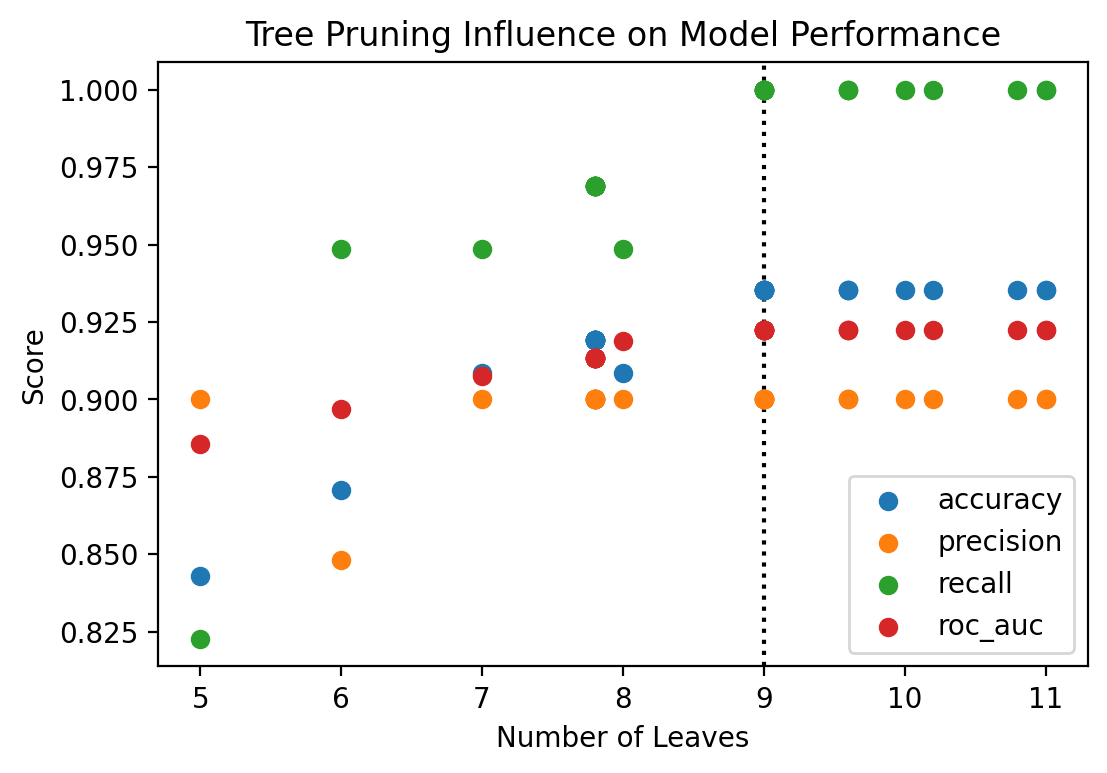

In [8]:
plt.figure(dpi=200)

x = fit_results['n_leaves']

for name, y in fit_results.drop(columns=['min_impurity_decrease', 'ccp_alpha', 'n_leaves', 'max_leaves']).iteritems():
    plt.scatter(x, y, label=name)

plt.title('Tree Pruning Influence on Model Performance')
plt.ylabel('Score')
plt.xlabel('Number of Leaves')
plt.axvline(9, color='k', ls=':', zorder=-1)
plt.legend()
plt.show()

In [9]:
final_pipe = build_pipe(0, 0, 9)
final_pipe.fit(claims_X, claims_y)
dump(final_pipe, './saved-models/decision-tree-claim-approval.joblib')

['./saved-models/decision-tree-claim-approval.joblib']

In [10]:
claims_test_df = pd.read_csv('../data/processed/dim_claims_test.csv')

claims_X_test = claims_test_df[['bin', 'drug']]
claims_y_test = claims_test_df['pharmacy_claim_approved']

In [11]:
test_accuracy = accuracy_score(claims_y_test, final_pipe.predict(claims_X_test))
test_precision = precision_score(claims_y_test, final_pipe.predict(claims_X_test))
test_recall = recall_score(claims_y_test, final_pipe.predict(claims_X_test))
test_roc_auc = roc_auc_score(claims_y_test, final_pipe.predict_proba(claims_X_test)[:, 1])
test_n_leaves = final_pipe['model'].get_n_leaves()

print(f'Test Accuracy = {round(test_accuracy, 2)}')
print(f'Test Precision = {round(test_precision, 2)}')
print(f'Test Recall = {round(test_recall, 2)}')
print(f'Test ROC AUC = {round(test_roc_auc, 2)}')
print(f'Test # Leaves = {test_n_leaves}')

Test Accuracy = 0.94
Test Precision = 0.9
Test Recall = 1.0
Test ROC AUC = 0.92
Test # Leaves = 9
